# RNN Model update

In [21]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf
from tensorflow.keras import Sequential



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
dataset = '/Users/kieran/Desktop/Le Wag/train1_update.csv'
df = pd.read_csv(dataset)
display(df)

,id,cycle,setting1,setting2,T24_Total_temperature_at_LPC_outlet,T30_Total_temperature_at_HPC_outlet,T50_Total_temperature_at_LPT_outlet,P30_Total_pressure_at_HPC_outlet,Nf_Physical_fan_speed,Nc_Physical_core_speed,Ps30_Static_pressure_at_HPC_outlet,phi_Ratio_of_fuel_flow_to_Ps30,NRf_Corrected_fan_speed,NRc_Corrected_core_speed,BPR_Bypass_Ratio,htBleed_Bleed_Enthalpy,W31_HPT_coolant_bleed,W32_LPT_coolant_bleed,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [4]:
features = df.drop(['id', 'cycle', 'RUL'], axis=1)
target = df['RUL']

In [5]:
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)


In [6]:
def create_sequences(df, features, target, cycle_length, sequence_count):
    sequences = []
    rul_values = []
    
    for engine_id in df['id'].unique():
        engine_data = features[df['id'] == engine_id]
        engine_rul = target[df['id'] == engine_id]
        
        for i in range(0, len(engine_data) - cycle_length * sequence_count + 1, cycle_length):
            seq = []
            for j in range(sequence_count):
                seq.append(engine_data[i + j * cycle_length : i + (j + 1) * cycle_length])
            sequences.append(np.concatenate(seq))
            rul_values.append(engine_rul.iloc[i + cycle_length * sequence_count - 1])
    
    return np.array(sequences), np.array(rul_values)

In [27]:
cycle_length = 30
sequence_count = 1 
sequences, rul_values = create_sequences(df, features_norm, target, cycle_length, sequence_count)

In [28]:
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = rul_values[:split_index], rul_values[split_index:]


In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((514, 30, 16), (129, 30, 16), (514,), (129,))

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

def build_rnn_model(input_shape):
    """
    Builds and compiles an RNN model.
    
    Parameters:
    input_shape (tuple): The shape of the input data (sequence_length, number_of_features).
    
    Returns:
    model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    # model.compile(optimizer='adam', loss='mean_squared_error')
    # return model

    model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    return model

# Build the model
input_shape = (cycle_length * sequence_count, features.shape[1])
model = build_rnn_model(input_shape)

# Display the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 50)         │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,651 (131.45 KB)

 Trainable params: 33,651 (131.45 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 96.3724 - val_loss: 108.6859
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 94.1190 - val_loss: 105.7565
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 91.2644 - val_loss: 103.6470
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 89.6355 - val_loss: 102.0120
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 85.5893 - val_loss: 100.9444
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 86.5891 - val_loss: 100.2615
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 84.5207 - val_loss: 99.7096
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 85.6131 - val_loss: 99.2148
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 84.3819 - val_loss: 98.7526
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 82.4832 - val_loss: 98.3091
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 85.0769 - val_loss: 97.8799
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 96.8994  
Test Loss: 94.48007202148438
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean Absolute Error (MAE): 94.97757784525554
Mean Squared Error (MSE): 14337.756330610664
Root Mean Squared Error (RMSE): 119.74037051308412


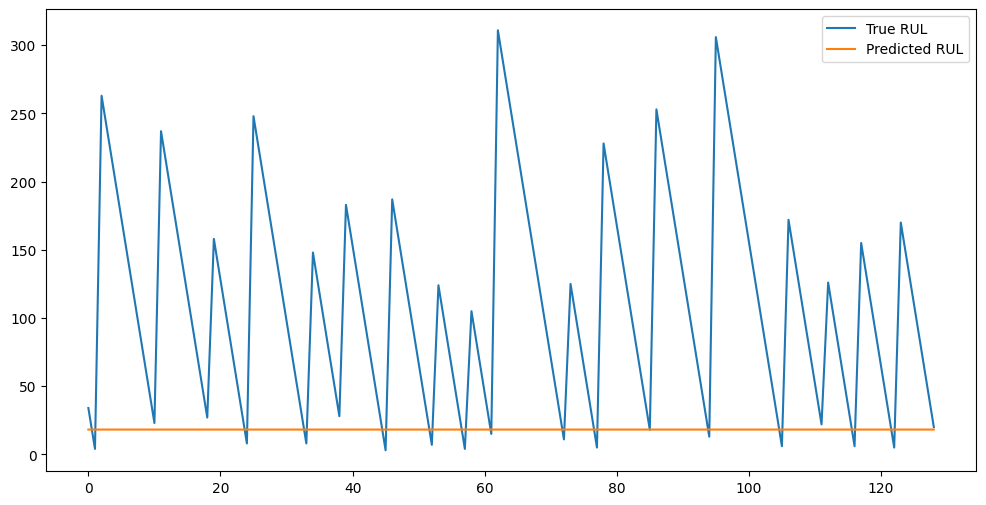

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Compute additional metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Compare predictions to the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True RUL')
plt.plot(predictions, label='Predicted RUL')
plt.legend()
plt.show()